In [1006]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

---

# Web Scraping

In [1007]:
url = "https://www.airlinequality.com/airline-reviews/british-airways/page/1/?sortby=post_date%3ADesc&pagesize=100"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [1008]:
review_rating_header = set()
for i in soup.find_all('td', class_='review-rating-header'):
    review_rating_header.add(i.text)

lists_dict = {}
for h in review_rating_header:
    lists_dict[h] = []
    
print(review_rating_header)
print(lists_dict)

ls_ratingValue = []
ls_user_loc = []
ls_trip_verified = []

{'Seat Comfort', 'Recommended', 'Wifi & Connectivity', 'Food & Beverages', 'Ground Service', 'Seat Type', 'Aircraft', 'Inflight Entertainment', 'Value For Money', 'Date Flown', 'Cabin Staff Service', 'Route', 'Value for Money', 'Type Of Traveller', 'Staff Service'}
{'Seat Comfort': [], 'Recommended': [], 'Wifi & Connectivity': [], 'Food & Beverages': [], 'Ground Service': [], 'Seat Type': [], 'Aircraft': [], 'Inflight Entertainment': [], 'Value For Money': [], 'Date Flown': [], 'Cabin Staff Service': [], 'Route': [], 'Value for Money': [], 'Type Of Traveller': [], 'Staff Service': []}


In [1009]:
max_page = int(soup.find('a', href="/airline-reviews/british-airways/page/37/?sortby=post_date%3ADesc&pagesize=100").text)

for page in range(1, max_page+1):
    url = "https://www.airlinequality.com/airline-reviews/british-airways/page/"+str(page)+"/?sortby=post_date%3ADesc&pagesize=100"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
#     print(url)
    
    for content in soup.find_all('article', itemprop="review"):        
        ratingValue = content.find('span', itemprop="ratingValue")
        if ratingValue != None:
            ratingValue = int(ratingValue.text)
        else:
            ratingValue = np.nan 
        ls_ratingValue.append(ratingValue)
#         print('Score:', ratingValue)
        
        user_loc = content.find('h3', class_="text_sub_header").text
        if "(" in user_loc:
            user_loc = user_loc.split("(")[1].split(")")[0]
        else:
            user_loc = np.nan #
        ls_user_loc.append(user_loc)
#         print('User Location:',user_loc)

        trip_verified_tag = soup.find('a', href=lambda href: href and 'verified-reviews' in href)

        if trip_verified_tag:
            trip_verified = trip_verified_tag.text.strip()
            ls_trip_verified.append(trip_verified)
        else:
            ls_trip_verified.append(np.nan) 
            
#         print("----------------------------------------")

        for lists_dict_element in lists_dict:
            flag=1
            for i in content.find_all('td', class_='review-rating-header'):
                if(lists_dict_element == i.text):
                    if(i.find_next_sibling().text=='12345'):
#                         print(i.text, ':', i.find_next_sibling().find_all('span', class_="star fill")[-1].text)
                        star_text = i.find_next_sibling().find_all('span', class_="star fill")[-1].text
                        if star_text!=None:
                            lists_dict[lists_dict_element].append(int(star_text))
                        else:
                            lists_dict[lists_dict_element].append(0)
                    else:    
#                         print(i.text, ':', i.find_next_sibling().text)
                        normal_text = i.find_next_sibling().text
                        if star_text==None:
                            lists_dict[lists_dict_element].append(np.nan)
                        else:
                            lists_dict[lists_dict_element].append(normal_text)
                    set_present.add(i.text)
                    flag=0
            if flag:
#                 print(lists_dict_element,': Flagged')
                lists_dict[lists_dict_element].append(np.nan) #
#         print("\n/////////////////////////////////////////////////////////////////////////////////////")

---

In [1010]:
df = pd.DataFrame()

df['ratingValue'] = ls_ratingValue
df['user_loc'] = ls_user_loc
df['trip_verified'] = ls_trip_verified

for i in review_rating_header:
    df[i] = lists_dict[i]

---
# EDA

In [1011]:
df

,ratingValue,user_loc,trip_verified,Seat Comfort,Recommended,Wifi & Connectivity,Food & Beverages,Ground Service,Seat Type,Aircraft,Inflight Entertainment,Value For Money,Date Flown,Cabin Staff Service,Route,Value for Money,Type Of Traveller,Staff Service
0,1.0,United Kingdom,Trip Verified,3.0,no,NaN,1,1.0,Economy Class,NaN,NaN,1,July 2023,3.0,Gatwick to Montpelier,NaN,Couple Leisure,NaN
1,9.0,Iceland,Trip Verified,4.0,yes,NaN,5,4.0,Business Class,Boeing 787-8,3,4,July 2023,5.0,London to Mumbai,NaN,Couple Leisure,NaN
2,6.0,Iceland,Trip Verified,3.0,yes,4.0,4,2.0,Business Class,A320,NaN,3,July 2023,5.0,Keflavik to London,NaN,Couple Leisure,NaN
3,1.0,Canada,Trip Verified,1.0,no,NaN,NaN,1.0,Economy Class,NaN,NaN,1,May 2023,1.0,Gibraltar to London Heathrow,NaN,Solo Leisure,NaN
4,1.0,Qatar,Trip Verified,1.0,no,NaN,NaN,1.0,Business Class,A321,NaN,1,July 2023,1.0,Madrid to London,NaN,Family Leisure,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,1.0,United Kingdom,NaN,3.0,no,NaN,2,NaN,Economy Class,NaN,N/A,3,NaN,1.0,NaN,NaN,NaN,NaN
3611,9.0,United Kingdom,NaN,4.0,yes,NaN,4,NaN,Business Class,NaN,N/A,3,NaN,5.0,NaN,NaN,NaN,NaN
3612,5.0,United Kingdom,NaN,NaN,yes,NaN,NaN,NaN,Economy Class,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
3613,4.0,United States,NaN,1.0,no,NaN,5,NaN,Premium Economy,NaN,N/A,1,NaN,3.0,NaN,NaN,NaN,NaN


In [1012]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3615 entries, 0 to 3614
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ratingValue             3610 non-null   float64
 1   user_loc                3613 non-null   object 
 2   trip_verified           2300 non-null   object 
 3   Seat Comfort            3507 non-null   float64
 4   Recommended             3615 non-null   object 
 5   Wifi & Connectivity     577 non-null    float64
 6   Food & Beverages        3250 non-null   object 
 7   Ground Service          2773 non-null   float64
 8   Seat Type               3613 non-null   object 
 9   Aircraft                1876 non-null   object 
 10  Inflight Entertainment  2519 non-null   object 
 11  Value For Money         3615 non-null   object 
 12  Date Flown              2837 non-null   object 
 13  Cabin Staff Service     3497 non-null   float64
 14  Route                   2840 non-null   

In [1013]:
df.drop(columns=['Value for Money', 'Staff Service'], inplace=True)

In [1014]:
df['Inflight Entertainment'].value_counts()

1      768
3      541
4      461
2      427
5      312
N/A     10
Name: Inflight Entertainment, dtype: int64

In [1015]:
df.replace('N/A', np.nan, inplace=True)

In [1016]:
df['trip_verified'].value_counts()

Trip Verified      900
Verified Review    900
Not Verified       500
Name: trip_verified, dtype: int64

In [1017]:
df['trip_verified'].replace('Verified Review', 'Trip Verified', inplace=True)

In [1018]:
df

,ratingValue,user_loc,trip_verified,Seat Comfort,Recommended,Wifi & Connectivity,Food & Beverages,Ground Service,Seat Type,Aircraft,Inflight Entertainment,Value For Money,Date Flown,Cabin Staff Service,Route,Type Of Traveller
0,1.0,United Kingdom,Trip Verified,3.0,no,NaN,1.0,1.0,Economy Class,NaN,NaN,1.0,July 2023,3.0,Gatwick to Montpelier,Couple Leisure
1,9.0,Iceland,Trip Verified,4.0,yes,NaN,5.0,4.0,Business Class,Boeing 787-8,3.0,4.0,July 2023,5.0,London to Mumbai,Couple Leisure
2,6.0,Iceland,Trip Verified,3.0,yes,4.0,4.0,2.0,Business Class,A320,NaN,3.0,July 2023,5.0,Keflavik to London,Couple Leisure
3,1.0,Canada,Trip Verified,1.0,no,NaN,NaN,1.0,Economy Class,NaN,NaN,1.0,May 2023,1.0,Gibraltar to London Heathrow,Solo Leisure
4,1.0,Qatar,Trip Verified,1.0,no,NaN,NaN,1.0,Business Class,A321,NaN,1.0,July 2023,1.0,Madrid to London,Family Leisure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,1.0,United Kingdom,NaN,3.0,no,NaN,2.0,NaN,Economy Class,NaN,NaN,3.0,NaN,1.0,NaN,NaN
3611,9.0,United Kingdom,NaN,4.0,yes,NaN,4.0,NaN,Business Class,NaN,NaN,3.0,NaN,5.0,NaN,NaN
3612,5.0,United Kingdom,NaN,NaN,yes,NaN,NaN,NaN,Economy Class,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3613,4.0,United States,NaN,1.0,no,NaN,5.0,NaN,Premium Economy,NaN,NaN,1.0,NaN,3.0,NaN,NaN


In [1019]:
df.isna().sum()

ratingValue                  5
user_loc                     2
trip_verified             1315
Seat Comfort               108
Recommended                  0
Wifi & Connectivity       3038
Food & Beverages           366
Ground Service             842
Seat Type                    2
Aircraft                  1739
Inflight Entertainment    1106
Value For Money              1
Date Flown                 778
Cabin Staff Service        118
Route                      775
Type Of Traveller          770
dtype: int64

In [1020]:
for i in df.columns:
    if i in ['ratingValue', 'Seat Comfort', 'Wifi & Connectivity', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Value For Money', 'Cabin Staff Service']:
        df[i].fillna(0, inplace=True)
        df[i] = df[i].astype('int')


In [1021]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3615 entries, 0 to 3614
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ratingValue             3615 non-null   int32 
 1   user_loc                3613 non-null   object
 2   trip_verified           2300 non-null   object
 3   Seat Comfort            3615 non-null   int32 
 4   Recommended             3615 non-null   object
 5   Wifi & Connectivity     3615 non-null   int32 
 6   Food & Beverages        3615 non-null   int32 
 7   Ground Service          3615 non-null   int32 
 8   Seat Type               3613 non-null   object
 9   Aircraft                1876 non-null   object
 10  Inflight Entertainment  3615 non-null   int32 
 11  Value For Money         3615 non-null   int32 
 12  Date Flown              2837 non-null   object
 13  Cabin Staff Service     3615 non-null   int32 
 14  Route                   2840 non-null   object
 15  Type

---
# Data Visualization

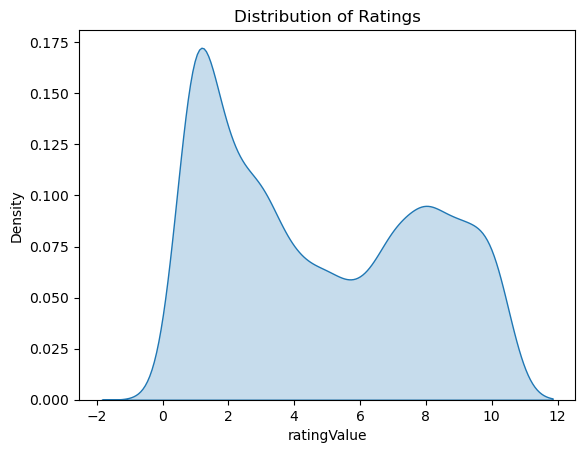

In [1022]:
sns.kdeplot(df['ratingValue'], shade=True)
plt.title('Distribution of Ratings')
plt.show()

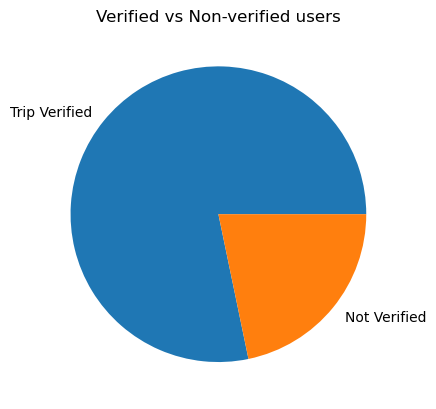

In [1023]:
plt.pie(x=df['trip_verified'].value_counts().tolist(), labels=df['trip_verified'].value_counts().keys().tolist())
plt.title('Verified vs Non-verified users')
plt.show()

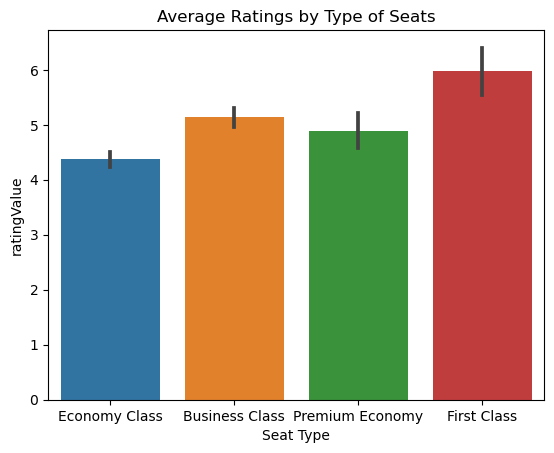

In [1024]:
sns.barplot(data=df, x='Seat Type', y='ratingValue')
plt.title('Average Ratings by Type of Seats')
plt.show()

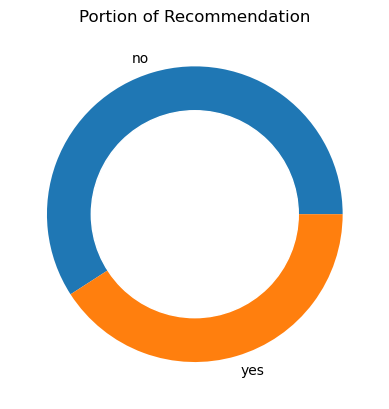

In [1025]:
plt.pie(x=df['Recommended'].value_counts().tolist(), labels=df['Recommended'].value_counts().keys().tolist())
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Portion of Recommendation')
plt.show()

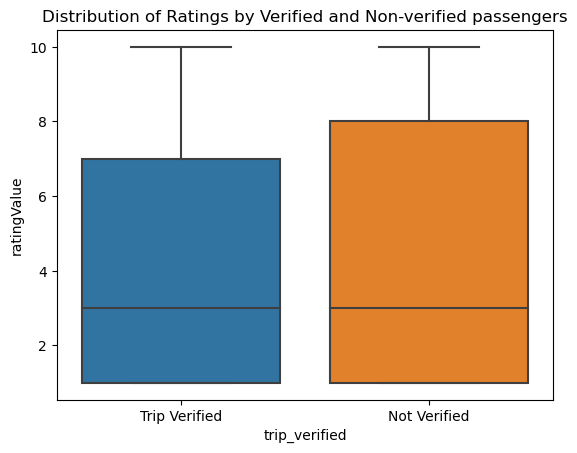

In [1042]:
sns.boxplot(data=df[df['ratingValue']==9], x='trip_verified', y='ratingValue')
plt.title('Distribution of Ratings by Verified and Non-verified passengers')
plt.show()

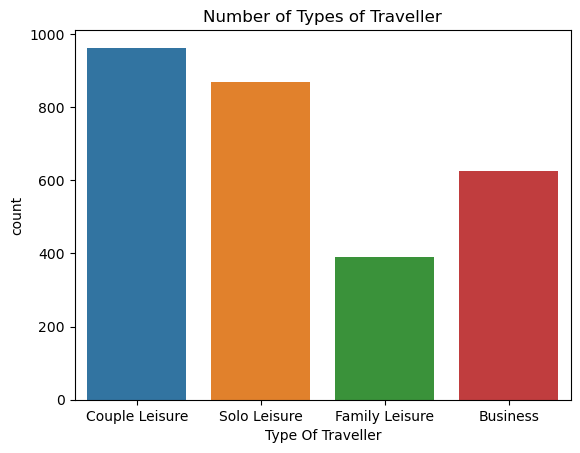

In [1027]:
sns.countplot(data=df, x='Type Of Traveller')
plt.title('Number of Types of Traveller')
plt.show()

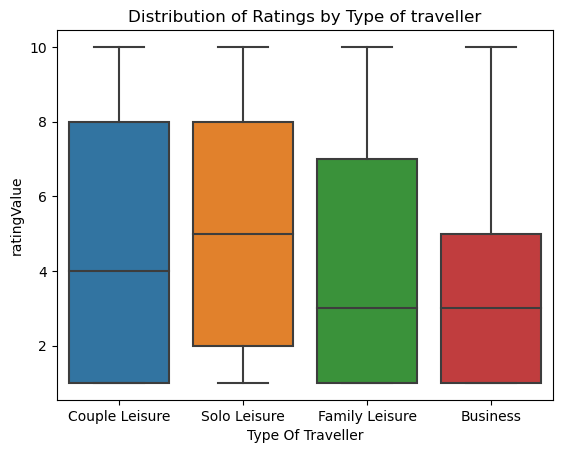

In [1040]:
sns.boxplot(data=df, x='Type Of Traveller', y='ratingValue')
plt.title('Distribution of Ratings by Type of traveller')
plt.show()

In [1029]:
df

,ratingValue,user_loc,trip_verified,Seat Comfort,Recommended,Wifi & Connectivity,Food & Beverages,Ground Service,Seat Type,Aircraft,Inflight Entertainment,Value For Money,Date Flown,Cabin Staff Service,Route,Type Of Traveller
0,1,United Kingdom,Trip Verified,3,no,0,1,1,Economy Class,NaN,0,1,July 2023,3,Gatwick to Montpelier,Couple Leisure
1,9,Iceland,Trip Verified,4,yes,0,5,4,Business Class,Boeing 787-8,3,4,July 2023,5,London to Mumbai,Couple Leisure
2,6,Iceland,Trip Verified,3,yes,4,4,2,Business Class,A320,0,3,July 2023,5,Keflavik to London,Couple Leisure
3,1,Canada,Trip Verified,1,no,0,0,1,Economy Class,NaN,0,1,May 2023,1,Gibraltar to London Heathrow,Solo Leisure
4,1,Qatar,Trip Verified,1,no,0,0,1,Business Class,A321,0,1,July 2023,1,Madrid to London,Family Leisure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,1,United Kingdom,NaN,3,no,0,2,0,Economy Class,NaN,0,3,NaN,1,NaN,NaN
3611,9,United Kingdom,NaN,4,yes,0,4,0,Business Class,NaN,0,3,NaN,5,NaN,NaN
3612,5,United Kingdom,NaN,0,yes,0,0,0,Economy Class,NaN,0,4,NaN,0,NaN,NaN
3613,4,United States,NaN,1,no,0,5,0,Premium Economy,NaN,0,1,NaN,3,NaN,NaN


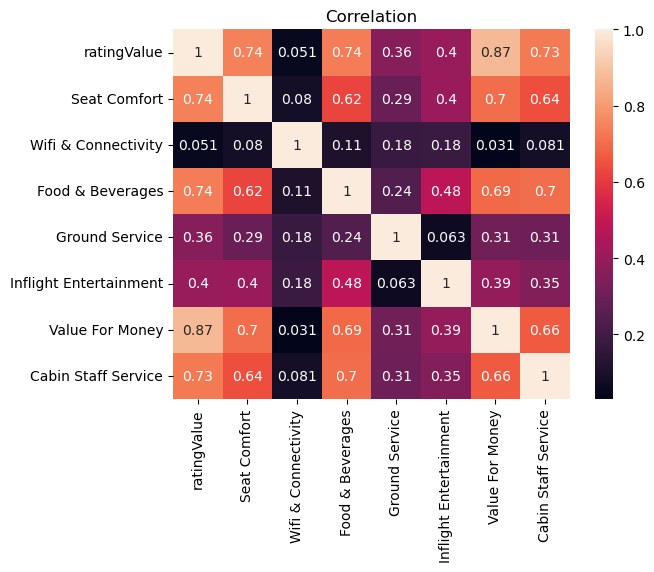

In [1030]:
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation')
plt.show()

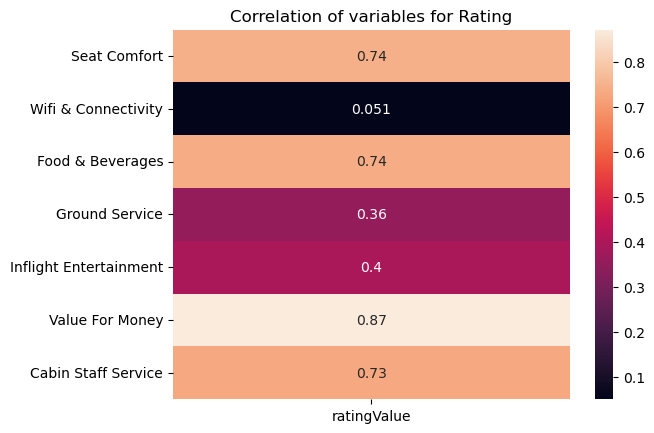

In [1031]:
sns.heatmap(df.corr()['ratingValue'].iloc[1:].to_frame(), annot=True)
plt.title('Correlation of variables for Rating')
plt.show()

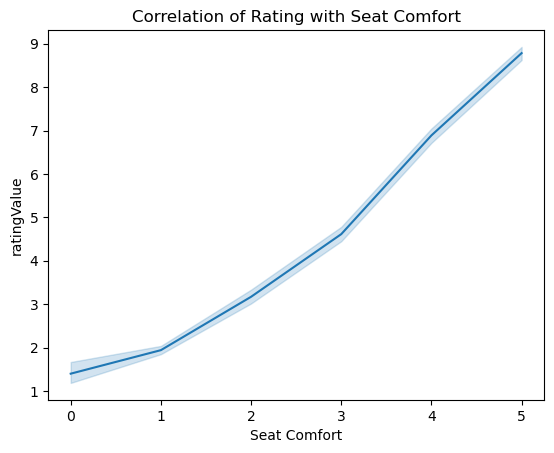

In [1032]:
sns.lineplot(data=df, x='Seat Comfort', y='ratingValue')
plt.title('Correlation of Rating with Seat Comfort')
plt.show()

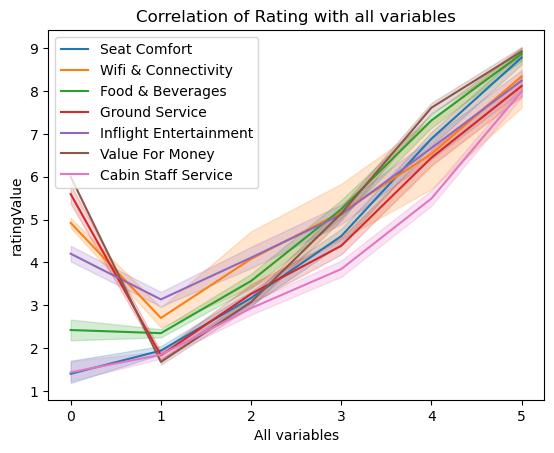

In [1033]:
for i in ['Seat Comfort', 'Wifi & Connectivity', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Value For Money', 'Cabin Staff Service']:
    sns.lineplot(data=df, x=i, y='ratingValue', label=i)
plt.xlabel('All variables')
plt.title('Correlation of Rating with all variables')
plt.show()